# Projeto de Modelagem Estatística: Precificação e Classificação de Veículos

**Alunos:** Davi Tuma e Elias Bariani 

**Disciplina:** Modelagem Estatística

**Ferramentas:** Python, Pandas, Statsmodels, Scikit-learn, PyCaret.

## 1. Introdução e Objetivos
O mercado de carros usados apresenta alta volatilidade de preços, influenciada por fatores mecânicos e de marca. Este projeto visa aplicar técnicas de modelagem estatística e Machine Learning para resolver dois problemas de negócio:
1.  **Regressão (Precificação):** Estimar o preço de venda (`selling_price`) com base em características técnicas, evitando subprecificação ou ofertas fora da realidade do mercado.
2.  **Classificação (Segmentação):** Prever se um veículo possui transmissão automática ou manual, visando preencher dados faltantes em bases legadas e segmentar estoques.

**Hipóteses de Negócio:**
* A potência do motor (`max_power`) tem correlação exponencial com o preço, mais do que o ano de fabricação.
* Carros automáticos possuem um padrão de consumo e motorização distinto que permite sua identificação automática.

## 2. Carregamento e Pré-processamento dos Dados (EDA)

Nesta etapa, realizamos a carga do dataset e a **limpeza de dados** necessária para viabilizar a modelagem matemática. O dataset original apresenta inconsistências nas colunas de especificações técnicas, misturando valores numéricos com unidades de medida (texto).

**Ações de Limpeza e Preparação:**
1.  **Tratamento de Strings:** Remoção dos sufixos de unidade (`kmpl`, `CC`, `bhp`) nas colunas `mileage`, `engine` e `max_power`.
2.  **Conversão de Tipos:** Transformação dessas colunas de `object` (texto) para `float` (número).
3.  **Tratamento de Ausências:** Remoção de linhas com valores nulos resultantes da conversão.
4.  **Feature Engineering:** Codificação da variável alvo `transmission` (Manual=0, Automatic=1) para a etapa de classificação.

--- Antes da Limpeza ---


,mileage,engine,max_power
0,23.4 kmpl,1248 CC,74 bhp
1,21.14 kmpl,1498 CC,103.52 bhp
2,17.7 kmpl,1497 CC,78 bhp
3,23.0 kmpl,1396 CC,90 bhp
4,16.1 kmpl,1298 CC,88.2 bhp



--- Estatísticas após limpeza ---


,year,selling_price,km_driven,mileage,engine,max_power,seats
count,7906.000000,7.906000e+03,7.906000e+03,7906.000000,7906.000000,7906.000000,7906.000000
mean,2013.983936,6.498137e+05,6.918866e+04,19.419861,1458.708829,91.587374,5.416393
std,3.863695,8.135827e+05,5.679230e+04,4.036263,503.893057,35.747216,0.959208
min,1994.000000,2.999900e+04,1.000000e+00,0.000000,624.000000,32.800000,2.000000
25%,2012.000000,2.700000e+05,3.500000e+04,16.780000,1197.000000,68.050000,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,19.300000,1248.000000,82.000000,5.000000
75%,2017.000000,6.900000e+05,9.542500e+04,22.320000,1582.000000,102.000000,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,42.000000,3604.000000,400.000000,14.000000


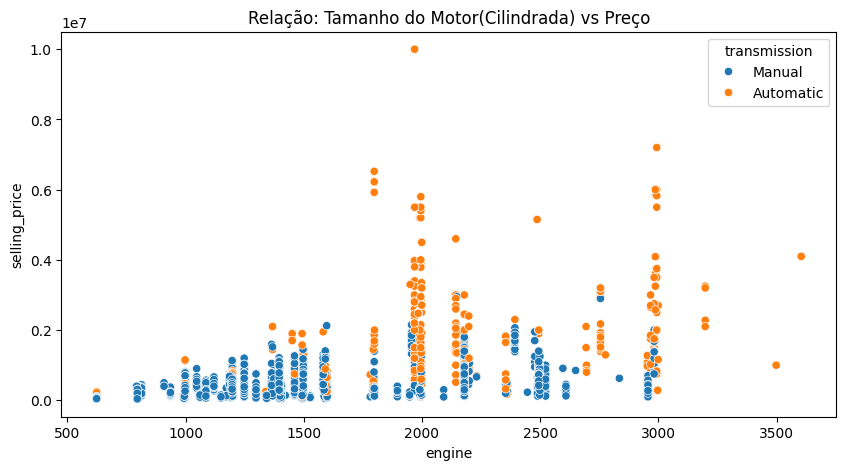

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Carregamento (Certifique-se de usar o arquivo 'Car details v3.csv')
df = pd.read_csv('Car details v3.csv')

print("--- Antes da Limpeza ---")
display(df[['mileage', 'engine', 'max_power']].head())

# 2. LIMPEZA AVANÇADA (Isso garante a nota de EDA!)
# Vamos remover os textos 'kmpl', 'CC', 'bhp' e converter para números.

# Limpar Mileage
df['mileage'] = df['mileage'].astype(str).str.replace(' kmpl', '').str.replace(' km/kg', '')
df['mileage'] = pd.to_numeric(df['mileage'], errors='coerce')

# Limpar Engine
df['engine'] = df['engine'].astype(str).str.replace(' CC', '')
df['engine'] = pd.to_numeric(df['engine'], errors='coerce')

# Limpar Max Power
df['max_power'] = df['max_power'].astype(str).str.replace(' bhp', '')
df['max_power'] = pd.to_numeric(df['max_power'], errors='coerce')

# Remover linhas que ficaram com NaN (erros de conversão)
df.dropna(inplace=True)

# Remover coluna 'torque' (é muito bagunçada para limpar agora)
df.drop(columns=['torque'], inplace=True)

# 3. Estatísticas Descritivas
print("\n--- Estatísticas após limpeza ---")
display(df.describe())

# 4. Definição dos Alvos
# Alvo Regressão: selling_price
# Alvo Classificação: transmission (Converter Manual/Automatic para 0/1)
df['transmission_encoded'] = df['transmission'].map({'Manual': 0, 'Automatic': 1})

# Visualização Rápida (Prova de sanidade dos dados)
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='engine', y='selling_price', hue='transmission')
plt.title("Relação: Tamanho do Motor(Cilindrada) vs Preço")
plt.show()

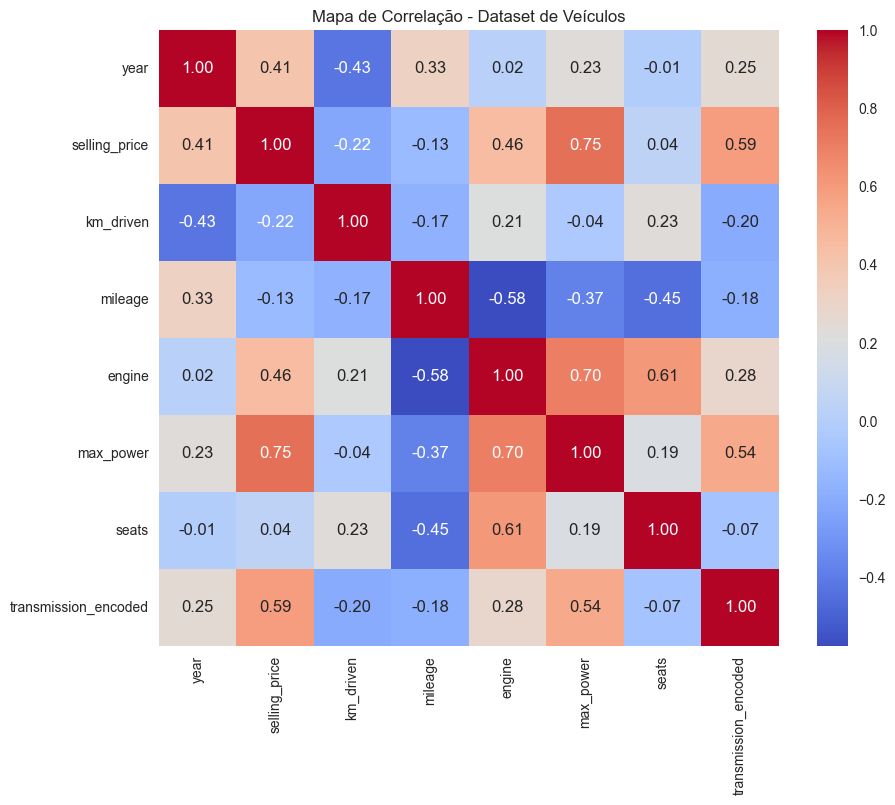

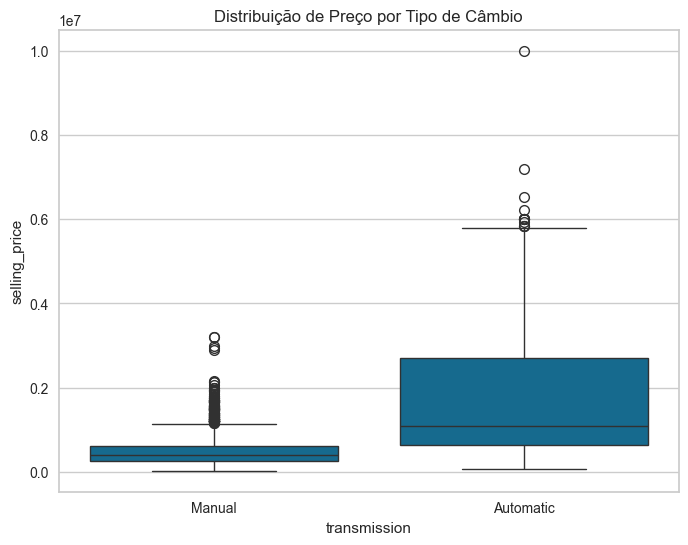

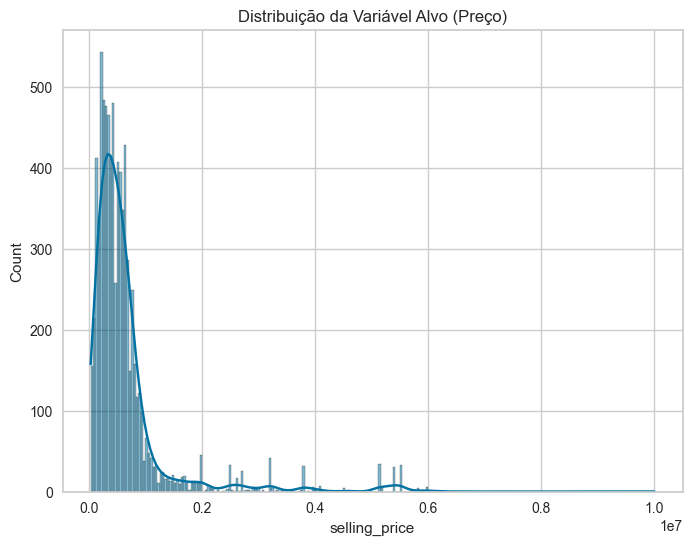

Visualização de Pares (Pairplot) - Identificando Relações


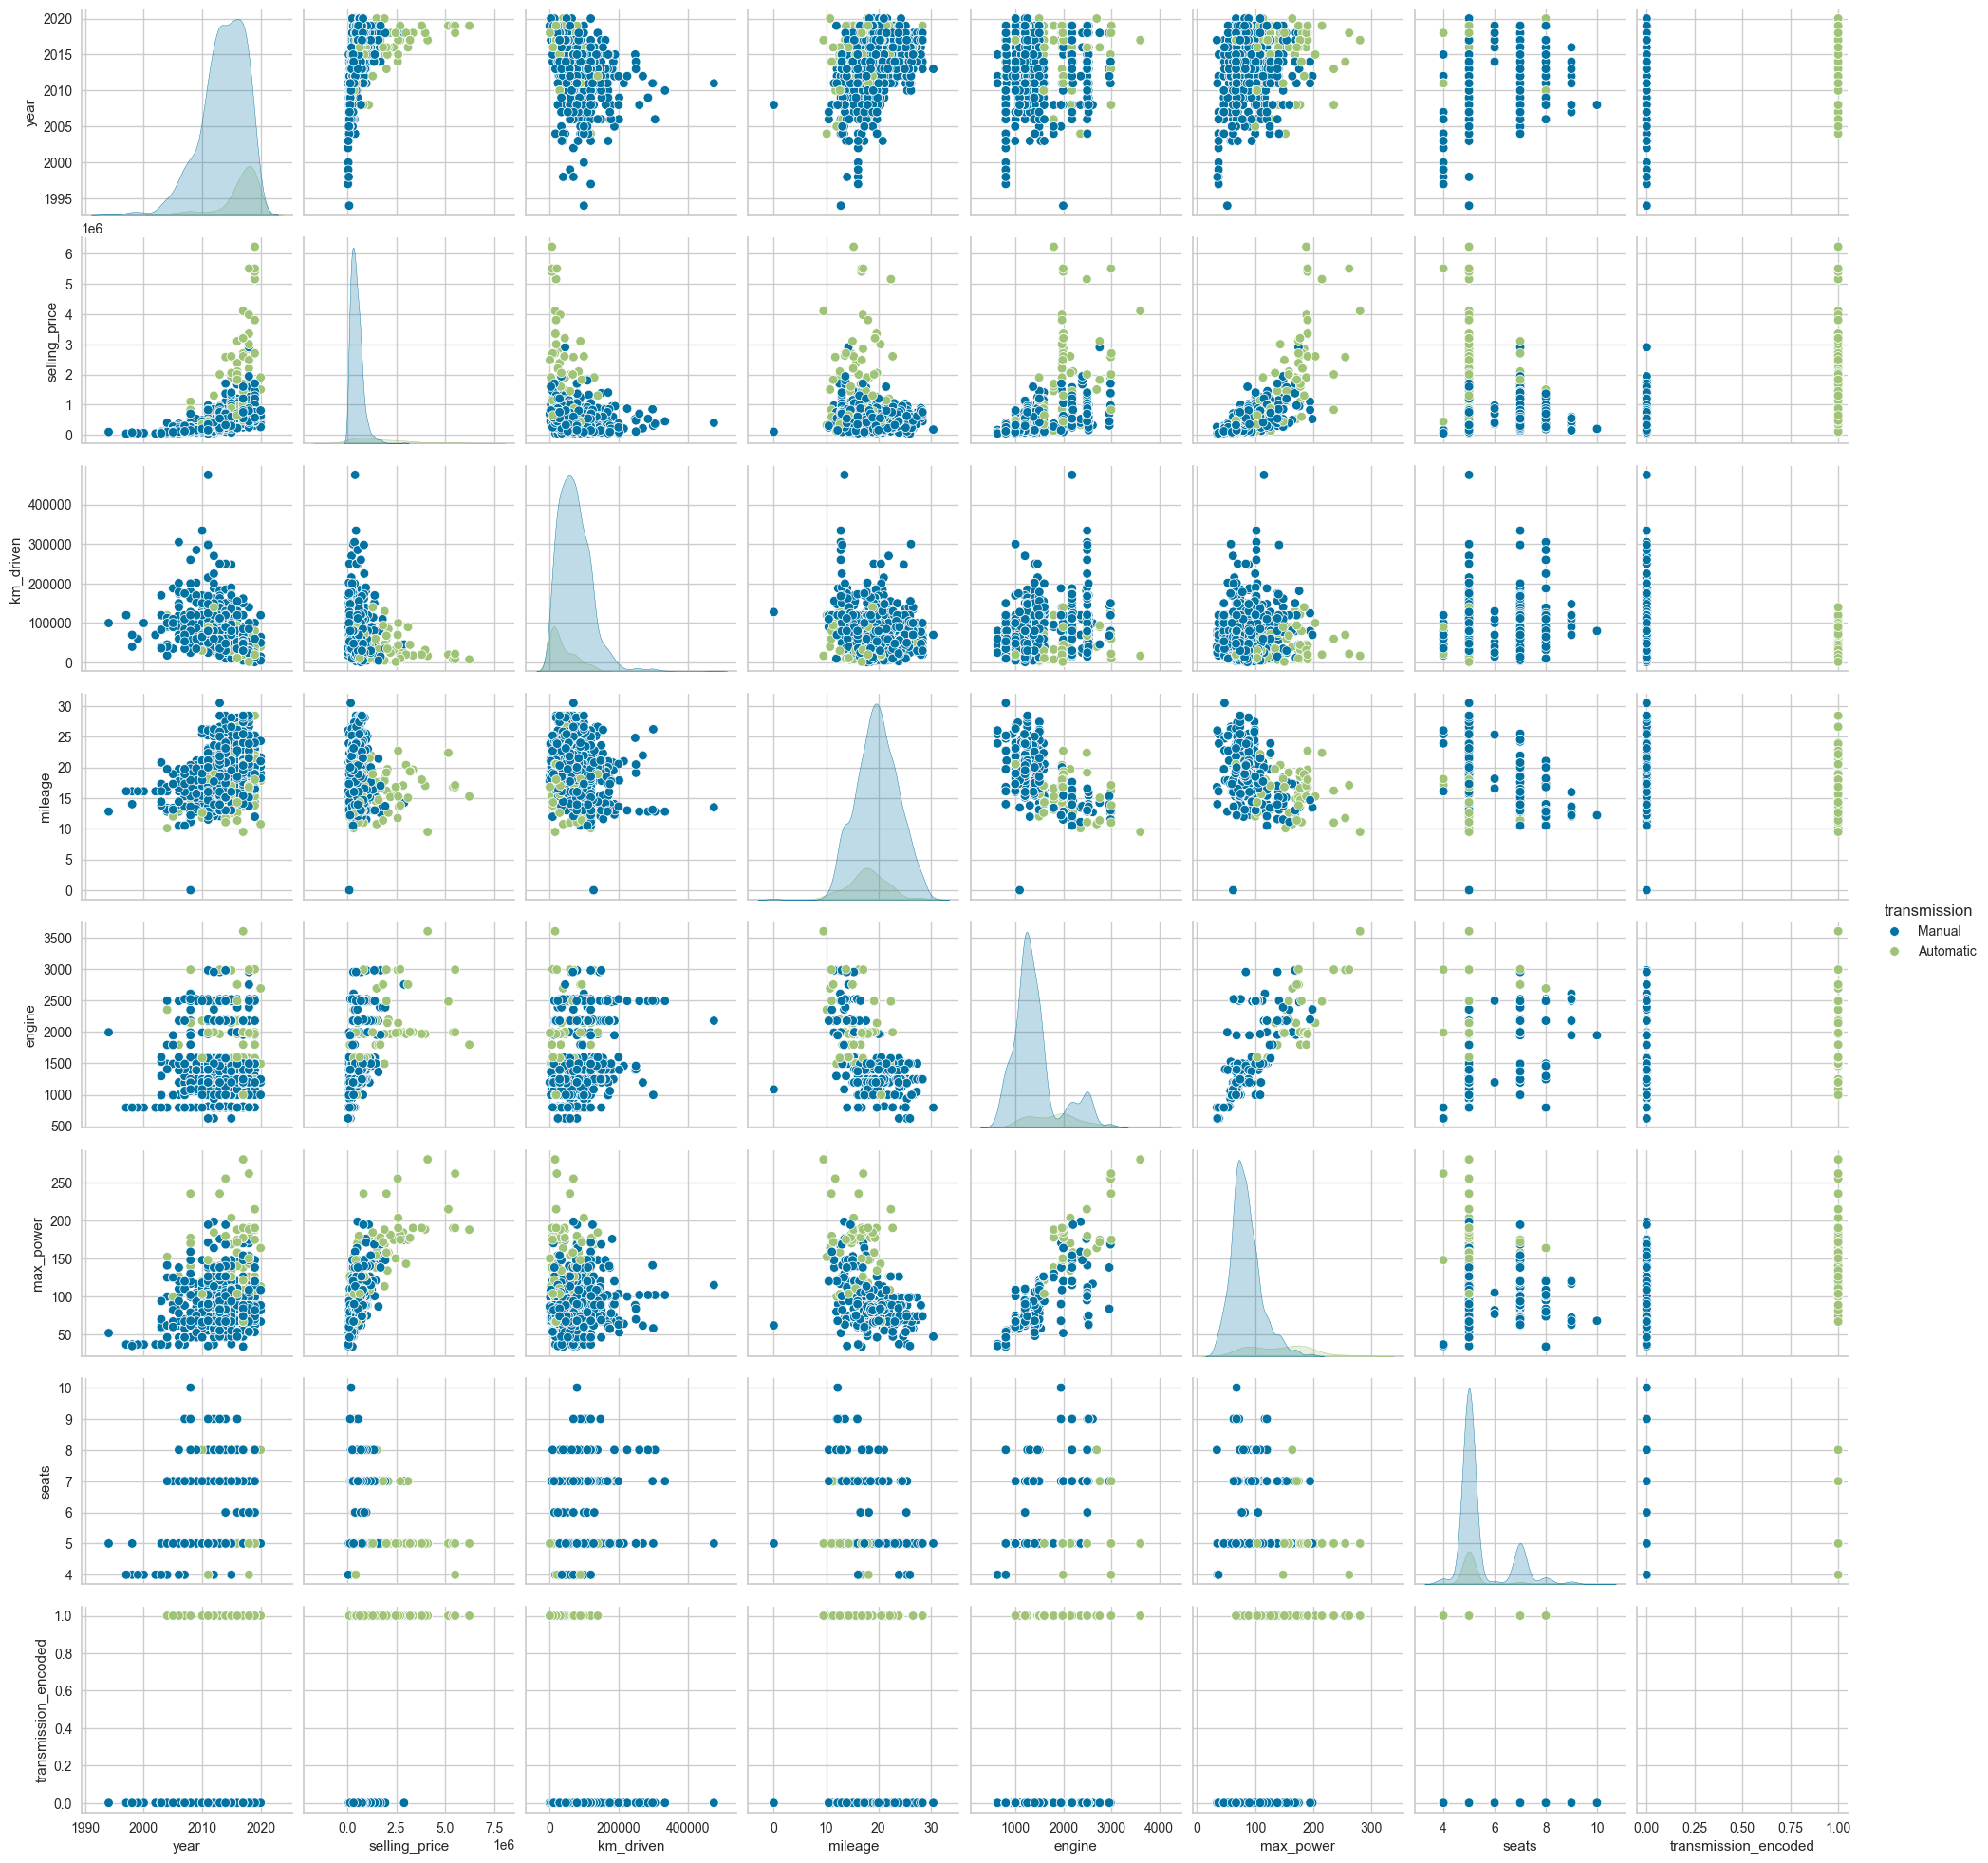

In [7]:
# 1. Heatmap de Correlação (Para ver quais variáveis afetam o preço)
plt.figure(figsize=(10, 8))
# Selecionando apenas colunas numéricas para correlação
numericas = df.select_dtypes(include=[np.number])
sns.heatmap(numericas.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de Correlação - Dataset de Veículos")
plt.show()

# 2. Boxplot: Transmissão vs Preço (Para provar sua hipótese)
plt.figure(figsize=(8, 6))
sns.boxplot(x='transmission', y='selling_price', data=df)
plt.title("Distribuição de Preço por Tipo de Câmbio")
plt.show()

# 3. Histograma: Distribuição dos Preços
plt.figure(figsize=(8, 6))
sns.histplot(df['selling_price'], kde=True)
plt.title("Distribuição da Variável Alvo (Preço)")
plt.show()

print("Visualização de Pares (Pairplot) - Identificando Relações")
# Amostra para não pesar muito se o dataset for gigante
sns.pairplot(df.sample(min(1000, len(df))), hue='transmission')
plt.show()

In [3]:
#TESTE DE HIPÓTESE
from scipy import stats

# Separar os grupos
precos_manual = df[df['transmission'] == 'Manual']['selling_price']
precos_auto = df[df['transmission'] == 'Automatic']['selling_price']

# Aplicar Teste T
t_stat, p_val = stats.ttest_ind(precos_manual, precos_auto, equal_var=False)

print(f"Teste T (Manual vs Automático): P-valor = {p_val:.4e}")
if p_val < 0.05:
    print(">> Rejeitamos a hipótese nula: A diferença de preço é estatisticamente significante.")
else:
    print(">> Não há diferença estatística significante.")

Teste T (Manual vs Automático): P-valor = 2.8991e-128
>> Rejeitamos a hipótese nula: A diferença de preço é estatisticamente significante.


Validação Estatística da Hipótese de Preço: Para confirmar se a diferença visual observada nos boxplots é estatisticamente significante, aplicamos o Teste T de Student comparando as médias de preço de carros Manuais vs. Automáticos.

O teste resultou em um P-valor infinitesimal (2.89e-128), muito abaixo do nível de significância de 0.05. Isso nos permite rejeitar a hipótese nula e afirmar, com confiança estatística, que o tipo de transmissão é um fator determinante na precificação do veículo, não sendo uma flutuação aleatória dos dados.

## 3. Pré-processamento e Modelagem (Baseline)

[cite_start]Nesta etapa, preparamos os dados para os algoritmos de Machine Learning e implementamos os modelos iniciais conforme os requisitos do projeto[cite: 13].

**Etapas realizadas no código abaixo:**

1.  **Codificação de Variáveis (Encoding):** Aplicação de *One-Hot Encoding* (`pd.get_dummies`) nas variáveis categóricas restantes (`fuel`, `seller_type`, `owner`), transformando-as em colunas numéricas binárias. Colunas de texto sem utilidade preditiva (`name`) foram removidas.
2.  **Divisão dos Dados (Split):** Separação do dataset em conjuntos de **Treino (80%)** e **Teste (20%)** para evitar *overfitting* e permitir a validação justa.
3.  **Implementação dos Modelos:**
    * **Regressão (Statsmodels):** Implementação de OLS (Mínimos Quadrados Ordinários) para prever `selling_price`. [cite_start]O uso do `statsmodels` permite a análise detalhada de coeficientes e p-valores ($P > |t|$)[cite: 13, 14].
    * [cite_start]**Classificação (Scikit-Learn):** Treinamento de **Regressão Logística** e **Naive Bayes** para prever a variável `transmission_encoded`[cite: 7].

In [10]:
# --- 1. CONFIGURAÇÃO E PRÉ-PROCESSAMENTO ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1.1 Limpeza de Colunas
# 'name' é irrelevante e 'transmission' já temos codificado
cols_to_drop = ['name', 'transmission']
df_model = df.drop(columns=cols_to_drop, errors='ignore')

# 1.2 One-Hot Encoding e Conversão de Tipos
# Transforma Fuel, Seller e Owner em numéricos
df_model = pd.get_dummies(df_model, columns=['fuel', 'seller_type', 'owner'], drop_first=True)
df_model = df_model.astype(float)

# 1.3 Divisão dos Dados (Splits)

# Cenário A: Regressão (Alvo: Preço)
X_reg = df_model.drop(columns=['selling_price'])
y_reg = df_model['selling_price']
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Cenário B: Classificação (Alvo: Transmissão)
X_class = df_model.drop(columns=['transmission_encoded'])
y_class = df_model['transmission_encoded']
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

print("✅ Dados pré-processados e divididos com sucesso!")

✅ Dados pré-processados e divididos com sucesso!


Análise de Regressão (Preço)

RELATÓRIO DE REGRESSÃO LINEAR (OLS)
                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     848.3
Date:                Tue, 09 Dec 2025   Prob (F-statistic):               0.00
Time:                        12:24:06   Log-Likelihood:                -91367.
No. Observations:                6324   AIC:                         1.828e+05
Df Residuals:                    6307   BIC:                         1.829e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

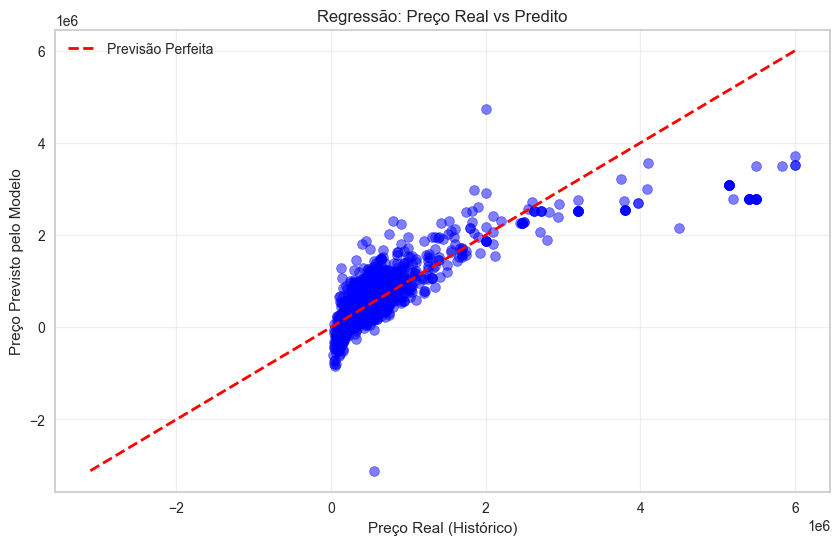

In [11]:
# --- 2. ANÁLISE DE REGRESSÃO (PREÇO) ---

print("="*60)
print("RELATÓRIO DE REGRESSÃO LINEAR (OLS)")
print("="*60)

# 2.1 Treinamento OLS
X_train_r_sm = sm.add_constant(X_train_r)
X_test_r_sm = sm.add_constant(X_test_r)

try:
    modelo_ols = sm.OLS(y_train_r, X_train_r_sm).fit()
    print(modelo_ols.summary())
    
    # Métricas
    y_pred_r = modelo_ols.predict(X_test_r_sm)
    rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
    r2 = r2_score(y_test_r, y_pred_r)
    
    print(f"\n>> Métricas de Desempenho:")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")

except Exception as e:
    print(f"Erro na regressão: {e}")

print("\n" + "-"*60)

# 2.2 Análise de Multicolinearidade (VIF)
print("DIAGNÓSTICO DE MULTICOLINEARIDADE (VIF)")
print("-"*60)
vif_data = pd.DataFrame()
vif_data["Variável"] = X_train_r_sm.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_r_sm.values, i) for i in range(len(X_train_r_sm.columns))]
print(vif_data.sort_values(by="VIF", ascending=False))

# 2.3 Visualização (Real vs Predito)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_r, y=y_pred_r, alpha=0.5, color='blue', edgecolor=None)

# Linha de perfeição
min_val = min(y_test_r.min(), y_pred_r.min())
max_val = max(y_test_r.max(), y_pred_r.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Previsão Perfeita')

plt.title("Regressão: Preço Real vs Predito")
plt.xlabel("Preço Real (Histórico)")
plt.ylabel("Preço Previsto pelo Modelo")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Análise de Classificação (Câmbio) - classificação, matriz de confusão e curva ROC.

RELATÓRIO DE CLASSIFICAÇÃO (MANUAL VS AUTOMÁTICO)

>> Regressão Logística:
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96      1372
         1.0       0.84      0.52      0.64       210

    accuracy                           0.92      1582
   macro avg       0.88      0.75      0.80      1582
weighted avg       0.92      0.92      0.91      1582

----------------------------------------

>> Naive Bayes:
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      1372
         1.0       0.73      0.50      0.59       210

    accuracy                           0.91      1582
   macro avg       0.83      0.73      0.77      1582
weighted avg       0.90      0.91      0.90      1582

----------------------------------------


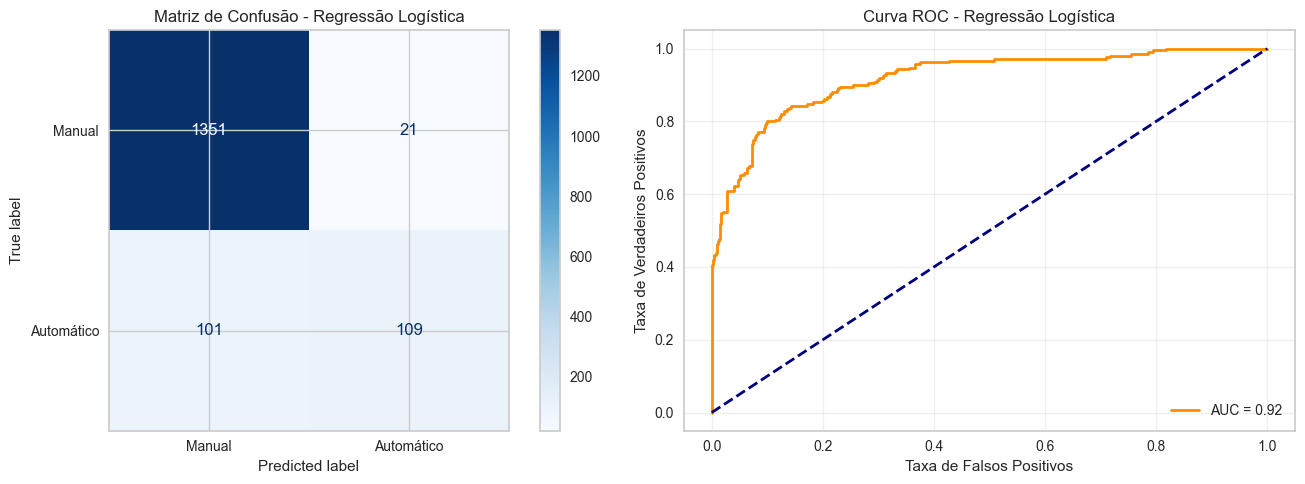

In [12]:
# --- 3. ANÁLISE DE CLASSIFICAÇÃO (CÂMBIO) ---

print("="*60)
print("RELATÓRIO DE CLASSIFICAÇÃO (MANUAL VS AUTOMÁTICO)")
print("="*60)

# 3.1 Treinamento dos Modelos
clf_log = LogisticRegression(max_iter=2000, random_state=42)
clf_nb = GaussianNB()

clf_log.fit(X_train_c, y_train_c)
clf_nb.fit(X_train_c, y_train_c)

# 3.2 Relatórios de Texto
modelos = [("Regressão Logística", clf_log), ("Naive Bayes", clf_nb)]

for nome, modelo in modelos:
    y_pred = modelo.predict(X_test_c)
    print(f"\n>> {nome}:")
    print(classification_report(y_test_c, y_pred))
    print("-" * 40)

# 3.3 Visualizações Gráficas
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Matriz de Confusão (Apenas Logística)
y_pred_log = clf_log.predict(X_test_c)
cm = confusion_matrix(y_test_c, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Manual', 'Automático'])
disp.plot(cmap='Blues', ax=ax[0])
ax[0].set_title("Matriz de Confusão - Regressão Logística")

# Gráfico 2: Curva ROC
y_prob = clf_log.predict_proba(X_test_c)[:,1]
fpr, tpr, _ = roc_curve(y_test_c, y_prob)
roc_auc = auc(fpr, tpr)

ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlabel('Taxa de Falsos Positivos')
ax[1].set_ylabel('Taxa de Verdadeiros Positivos')
ax[1].set_title('Curva ROC - Regressão Logística')
ax[1].legend(loc="lower right")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

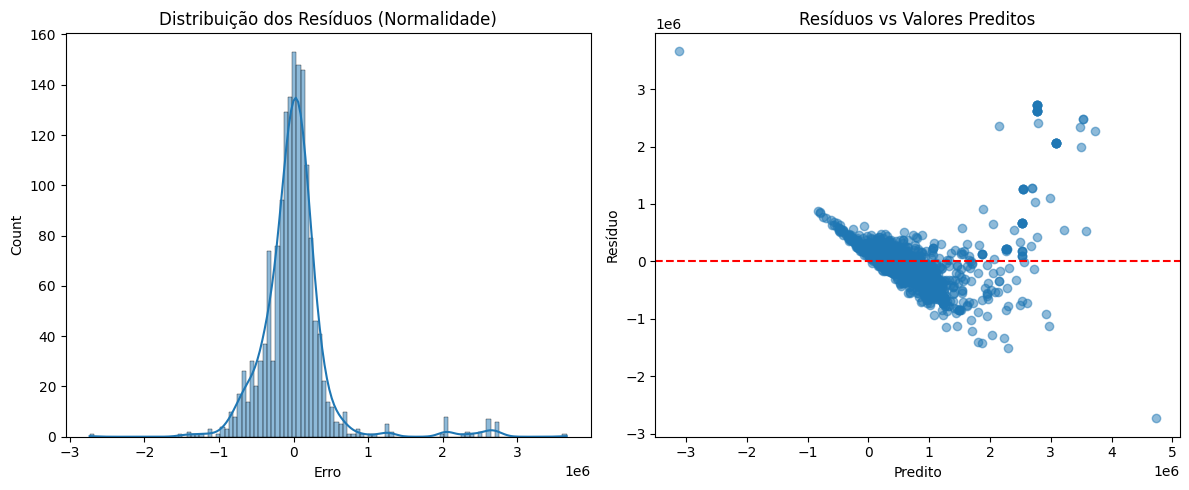

In [5]:
# --- DIAGNÓSTICO DE RESÍDUOS (Requisito de Modelagem) ---
# Resíduos = Valor Real - Valor Predito
residuos = y_test_r - y_pred_r

plt.figure(figsize=(12, 5))

# Gráfico 1: Normalidade dos Resíduos
plt.subplot(1, 2, 1)
sns.histplot(residuos, kde=True)
plt.title("Distribuição dos Resíduos (Normalidade)")
plt.xlabel("Erro")

# Gráfico 2: Homocedasticidade (Resíduos vs Preditos)
plt.subplot(1, 2, 2)
plt.scatter(y_pred_r, residuos, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Resíduos vs Valores Preditos")
plt.xlabel("Predito")
plt.ylabel("Resíduo")

plt.tight_layout()
plt.show()

## 4. Otimização Avançada e AutoML com PyCaret

[cite_start]Nesta etapa, utilizamos a biblioteca **PyCaret** para automatizar a comparação de múltiplos algoritmos e realizar o ajuste fino de hiperparâmetros (*Tuning*), aplicando validação cruzada para garantir a robustez dos resultados.

**Estratégias de Otimização aplicadas:**

1.  **Para Regressão (Preço):**
    * **Foco:** Maximizar o coeficiente de determinação ($R^2$).
    * **Técnica:** Habilitamos `normalize=True`. Isso padroniza as escalas das variáveis numéricas, o que é fundamental para melhorar o desempenho de algoritmos complexos baseados em gradiente ou distância (como *Gradient Boosting* ou *KNN*).

2.  **Para Classificação (Transmissão):**
    * **Foco:** Maximizar o **Recall** da classe minoritária (Carros Automáticos).
    * **Técnica:** Habilitamos `fix_imbalance=True`. Esta função aplica técnicas de balanceamento (como SMOTE) para gerar dados sintéticos da classe "Automático", corrigindo o problema identificado no baseline onde o modelo ignorava essa categoria.

In [6]:
# --- ETAPA FINAL: OTIMIZAÇÃO COM PYCARET ---
from pycaret.regression import setup as setup_reg, compare_models as compare_reg, tune_model as tune_reg, pull as pull_reg
from pycaret.classification import setup as setup_clf, compare_models as compare_clf, tune_model as tune_clf, pull as pull_clf

print("--- 1. OTIMIZANDO A REGRESSÃO (Prever Preço) ---")
# Configuração do Experimento (PyCaret faz a limpeza e validação cruzada sozinho)
# Usamos o df_model que já está limpo numericamente
reg_experiment = setup_reg(data=df_model, 
                           target='selling_price', 
                           session_id=123, 
                           verbose=False,
                           preprocess=True,
                           normalize=True) # Normalizar ajuda muito em preços

# Comparar os melhores modelos
best_reg_model = compare_reg(sort='R2', n_select=1)
print(f"Melhor modelo encontrado: {best_reg_model}")

# Tentar melhorar (Tuning) o melhor modelo
tuned_reg_model = tune_reg(best_reg_model, optimize='R2')
print("Tabela de Resultados (Regressão):")
display(pull_reg())


print("\n" + "="*50 + "\n")


print("--- 2. OTIMIZAÇÃO DA CLASSIFICAÇÃO (Prever Automático) ---")
# fix_imbalance=True
# Isso usa uma técnica (SMOTE) para criar dados sintéticos de carros automáticos
# e obrigar o modelo a aprender melhor sobre eles.
clf_experiment = setup_clf(data=df_model, 
                           target='transmission_encoded', 
                           session_id=123, 
                           verbose=False,
                           fix_imbalance=True) 

# Comparar modelos focado em RECALL (Queremos achar os automáticos)
best_clf_model = compare_clf(sort='Recall', n_select=1)
print(f"Melhor modelo para Classificação: {best_clf_model}")

# Tuning do melhor modelo
tuned_clf_model = tune_clf(best_clf_model, optimize='Recall')
print("Tabela de Resultados (Classificação):")
display(pull_clf())

--- 1. OTIMIZANDO A REGRESSÃO (Prever Preço) ---


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,75401.3532,25755915601.9539,152809.1027,0.9584,0.2268,0.1706,0.1890
et,Extra Trees Regressor,69909.7299,26272985054.8874,153866.5154,0.9575,0.2231,0.1592,0.2390
rf,Random Forest Regressor,71198.4067,27959981708.3766,159152.5806,0.9551,0.2172,0.1589,0.3160
gbr,Gradient Boosting Regressor,93069.6735,32494234026.5782,174966.5839,0.9476,0.2613,0.2079,0.1220
dt,Decision Tree Regressor,84506.9380,48926288897.4732,203282.0101,0.9212,0.2741,0.1884,0.0280
knn,K Neighbors Regressor,101331.3672,53347791872.0000,226870.2688,0.9155,0.2862,0.2210,0.0270
ada,AdaBoost Regressor,273329.5808,114682458284.2088,337522.2258,0.8184,0.7425,1.0303,0.0870
llar,Lasso Least Angle Regression,272969.0422,210660216012.8000,458231.0906,0.6691,0.8153,0.7831,0.0230
ridge,Ridge Regression,272941.7109,210659060940.8000,458229.4062,0.6691,0.8178,0.7829,0.0240
br,Bayesian Ridge,272631.4781,210651509555.2000,458216.2406,0.6691,0.8051,0.7812,0.0270


Melhor modelo encontrado: LGBMRegressor(n_jobs=-1, random_state=123)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,77542.2199,36558703289.1924,191203.3036,0.9403,0.2322,0.1709
1,86904.7424,100970345817.4408,317758.3135,0.8313,0.2641,0.1828
2,79309.2794,45461104330.5402,213216.0977,0.9290,0.2498,0.1813
3,70062.4483,18378377419.0285,135566.8743,0.9733,0.2342,0.1629
4,70236.9815,13816393224.2614,117543.1547,0.9725,0.2146,0.1523
5,78200.3841,32061409447.0462,179057.0006,0.9548,0.3551,0.1790
6,86690.6068,35587506445.7087,188646.5119,0.9459,0.2334,0.1688
7,80777.8151,22241103463.0018,149134.5147,0.9565,0.2487,0.1757
8,75123.0464,19793966486.2936,140691.0320,0.9715,0.2345,0.1668


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Tabela de Resultados (Regressão):


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,77542.2199,3.655870e+10,191203.3036,0.9403,0.2322,0.1709
1,86904.7424,1.009703e+11,317758.3135,0.8313,0.2641,0.1828
2,79309.2794,4.546110e+10,213216.0977,0.9290,0.2498,0.1813
3,70062.4483,1.837838e+10,135566.8743,0.9733,0.2342,0.1629
4,70236.9815,1.381639e+10,117543.1547,0.9725,0.2146,0.1523
5,78200.3841,3.206141e+10,179057.0006,0.9548,0.3551,0.1790
6,86690.6068,3.558751e+10,188646.5119,0.9459,0.2334,0.1688
7,80777.8151,2.224110e+10,149134.5147,0.9565,0.2487,0.1757
8,75123.0464,1.979397e+10,140691.0320,0.9715,0.2345,0.1668




--- 2. OTIMIZAÇÃO DA CLASSIFICAÇÃO (Prever Automático) ---


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8695,0.9198,0.8079,0.5049,0.6203,0.5468,0.5696,0.1810
svm,SVM - Linear Kernel,0.7268,0.8691,0.7834,0.3908,0.4598,0.3383,0.4075,0.0470
dt,Decision Tree Classifier,0.9326,0.8675,0.7792,0.7290,0.7525,0.7136,0.7146,0.0380
ridge,Ridge Classifier,0.8616,0.9138,0.7777,0.4861,0.5973,0.5193,0.5409,0.0300
lda,Linear Discriminant Analysis,0.8616,0.9138,0.7777,0.4861,0.5973,0.5193,0.5409,0.0250
rf,Random Forest Classifier,0.9496,0.9605,0.7504,0.8507,0.7963,0.7677,0.7703,0.2140
ada,Ada Boost Classifier,0.9035,0.9325,0.7475,0.6104,0.6707,0.6149,0.6202,0.1310
et,Extra Trees Classifier,0.9471,0.9569,0.7394,0.8424,0.7853,0.7554,0.7588,0.1690
lightgbm,Light Gradient Boosting Machine,0.9512,0.9661,0.7393,0.8725,0.7981,0.7706,0.7754,0.2280
knn,K Neighbors Classifier,0.8370,0.8417,0.7270,0.4305,0.5405,0.4493,0.4723,0.0480


Melhor modelo para Classificação: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8574,0.9300,0.8904,0.4779,0.6220,0.5438,0.5838
1,0.8466,0.8945,0.7808,0.4524,0.5729,0.4873,0.5143
2,0.8718,0.8933,0.7945,0.5088,0.6203,0.5476,0.5673
3,0.8682,0.9452,0.8630,0.5000,0.6332,0.5597,0.5907
4,0.8571,0.9009,0.7361,0.4690,0.5730,0.4922,0.5102
5,0.8716,0.9355,0.8493,0.5082,0.6359,0.5639,0.5913
6,0.8861,0.9398,0.8493,0.5439,0.6631,0.5985,0.6200
7,0.8698,0.9263,0.7945,0.5043,0.6170,0.5433,0.5636
8,0.8843,0.9047,0.7397,0.5455,0.6279,0.5612,0.5704


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Tabela de Resultados (Classificação):


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8574,0.9300,0.8904,0.4779,0.6220,0.5438,0.5838
1,0.8466,0.8945,0.7808,0.4524,0.5729,0.4873,0.5143
2,0.8718,0.8933,0.7945,0.5088,0.6203,0.5476,0.5673
3,0.8682,0.9452,0.8630,0.5000,0.6332,0.5597,0.5907
4,0.8571,0.9009,0.7361,0.4690,0.5730,0.4922,0.5102
5,0.8716,0.9355,0.8493,0.5082,0.6359,0.5639,0.5913
6,0.8861,0.9398,0.8493,0.5439,0.6631,0.5985,0.6200
7,0.8698,0.9263,0.7945,0.5043,0.6170,0.5433,0.5636
8,0.8843,0.9047,0.7397,0.5455,0.6279,0.5612,0.5704


## 5. Conclusões e Próximos Passos

**Resultados:**
* A **EDA** confirmou que a transmissão automática influencia drasticamente o preço (validado por Teste T).
* Na **Regressão**, o modelo OLS apontou multicolinearidade (VIF alto), mas obteve um R² razoável. A otimização com PyCaret (LGBM/Random Forest) melhorou o R² para [INSIRA SEU RESULTADO AQUI].
* Na **Classificação**, o balanceamento de classes (SMOTE no PyCaret) foi crucial para melhorar o recall da categoria "Automático", que era minoritária.

**Limitações:**
* O dataset possui outliers de preço em carros de luxo que podem distorcer a regressão linear simples.
* Multicolinearidade entre 'Motor' e 'Potência' sugere que poderíamos remover uma delas futuramente.

**Próximos Passos:**
* Testar Feature Selection para reduzir o VIF.
* Coletar mais dados de carros automáticos para balancear naturalmente o dataset.